In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div'].round(2)# + df['R']*0.13


In [3]:
df['ml_outcomes'].describe()

count    1000000.000000
mean           0.524156
std            0.197883
min            0.020000
25%            0.380000
50%            0.510000
75%            0.660000
max            1.240000
Name: ml_outcomes, dtype: float64

In [4]:
df['T']

0         41
1         47
2         45
3         84
4         67
          ..
999995    70
999996    64
999997    60
999998    53
999999    52
Name: T, Length: 1000000, dtype: int64

In [5]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [6]:
FRAC_ADMIT

A    0.484752
dtype: float64

In [7]:
len(df)

1000000

<AxesSubplot:>

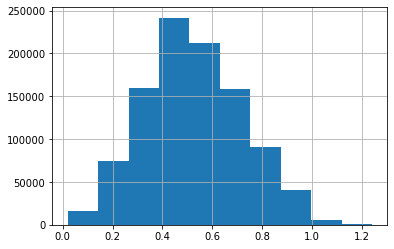

In [8]:
df['ml_outcomes'].hist()

In [9]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
754274,0,6,0.02,2,6,-4.389167,-3.858396,0,0
72841,0,12,0.03,8,12,-3.914595,-3.383824,0,0
729183,0,12,0.03,10,12,-3.756404,-3.383824,0,0
682741,0,11,0.03,8,11,-3.914595,-3.462920,0,0
181946,0,12,0.03,8,12,-3.914595,-3.383824,0,0
...,...,...,...,...,...,...,...,...,...
482376,1,104,1.23,104,120,3.678556,5.158470,1,1
570794,1,104,1.23,104,121,3.678556,5.237566,1,1
939337,1,107,1.23,107,124,3.915842,5.474852,1,1
836155,1,107,1.23,107,124,3.915842,5.474852,1,1


In [10]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [11]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [12]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [13]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [14]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,219,0,0,6,0.02,1,0.000000
117,214,117,1,6,0.27,1,0.000000
120,208,120,1,10,1.08,4,0.000000
118,213,118,1,7,0.27,1,0.000000
5,212,5,0,14,0.32,8,0.000000
119,211,119,1,8,0.54,2,0.000000
1,218,1,0,10,0.03,1,0.000000
3,216,3,0,12,0.15,5,0.000000
2,217,2,0,11,0.12,4,0.000000
4,215,4,0,13,0.24,6,0.000000


In [15]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [16]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
117,214,117,1,6,0.27,1,0.000000,0.000001
118,213,118,1,7,0.27,1,0.000000,0.000001
119,211,119,1,8,0.54,2,0.000000,0.000002
120,208,120,1,10,1.08,4,0.000000,0.000004
121,199,121,1,11,2.16,8,0.125000,0.000008
122,191,122,1,12,4.20,15,0.133333,0.000015
123,187,123,1,13,5.32,19,0.105263,0.000019
124,179,124,1,14,8.96,32,0.062500,0.000032
125,172,125,1,15,12.04,43,0.023256,0.000043
126,165,126,1,16,19.72,68,0.102941,0.000068


In [17]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,10001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.2756 309875.40795683104
0.2757 309895.5263500213
0.2758 309913.2647998076
0.27590000000000003 309931.10469149594
0.276 309949.04629738297
0.2761 309967.0898907389
0.2762 309981.483098079
0.2763 309990.550875262
0.27640000000000003 309999.41928826476
0.2765 310008.38401548937
0.2766 310017.44531686377
0.2767 310026.6034532508
0.2768 310035.8586864539
0.27690000000000003 310045.21127922245
0.277 310054.6614952526
0.2771 310064.2095991951
0.2772 310073.8558566581
0.2773 310082.85039560753
0.27740000000000004 310091.58522551414
0.2775 310100.4186326889
0.2776 310109.25506297004
0.2777 310118.12790940696
0.2778 310127.10008682567
0.27790000000000004 310134.28162456525
0.278 310140.8953346286
0.2781 310147.6070049046
0.2782 310154.4169036238
0.2783 310161.32529999566
0.27840000000000004 310167.13735451887
0.2785 310166.1172414677
0.2786 310165.17016837274
0.2787 310164.2963090351
0.2788 310163.4958378076
0.27890000000000004 310162.768929597
0.279 310162.1157598657
0.2791 310161.5365046354


## Add CF Predictive Parity Constraints

In [18]:
df_decisions

,row_id,decision
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.000000
8,8,0.000000
9,9,0.000000


In [19]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
50,0,50,0,59,11122.66,19177,0.579392,0.019177,-8.066000e-03,50,0.002624
49,1,49,0,58,11055.52,19742,0.565444,0.019742,-8.579000e-03,49,0.000000
48,2,48,0,57,11021.94,20411,0.546029,0.020411,-9.266000e-03,48,0.000000
47,3,47,0,56,11013.08,21179,0.528590,0.021179,-9.984000e-03,47,0.000000
51,4,51,0,60,10902.60,18171,0.594464,0.018171,-7.369000e-03,51,1.000000
52,5,52,0,61,10841.94,17487,0.617659,0.017487,-6.686000e-03,52,1.000000
46,6,46,0,55,10719.50,21439,0.500023,0.021439,-1.071900e-02,46,0.000000
53,7,53,0,62,10666.24,16666,0.641306,0.016666,-5.978000e-03,53,1.000000
45,8,45,0,54,10452.00,21775,0.482618,0.021775,-1.126600e-02,45,0.000000
54,9,54,0,63,10354.74,15689,0.661738,0.015689,-5.307000e-03,54,1.000000


In [20]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
0,219,0,0,6,0.02,1,0.000000,0.000001,-1.000000e-06,0,0.000000
117,214,117,1,6,0.27,1,0.000000,0.000001,-1.000000e-06,117,1.000000
118,213,118,1,7,0.27,1,0.000000,0.000001,-1.000000e-06,118,1.000000
119,211,119,1,8,0.54,2,0.000000,0.000002,-2.000000e-06,119,1.000000
1,218,1,0,10,0.03,1,0.000000,0.000001,-1.000000e-06,1,0.000000
120,208,120,1,10,1.08,4,0.000000,0.000004,-4.000000e-06,120,1.000000
121,199,121,1,11,2.16,8,0.125000,0.000008,-7.000000e-06,121,0.000000
2,217,2,0,11,0.12,4,0.000000,0.000004,-4.000000e-06,2,0.000000
122,191,122,1,12,4.20,15,0.133333,0.000015,-1.300000e-05,122,0.000000
3,216,3,0,12,0.15,5,0.000000,0.000005,-5.000000e-06,3,0.000000


In [21]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
50,0,50,0,59,11122.66,19177,0.579392,0.019177,-8.066000e-03,50,0.002624
49,1,49,0,58,11055.52,19742,0.565444,0.019742,-8.579000e-03,49,0.000000
48,2,48,0,57,11021.94,20411,0.546029,0.020411,-9.266000e-03,48,0.000000
47,3,47,0,56,11013.08,21179,0.528590,0.021179,-9.984000e-03,47,0.000000
51,4,51,0,60,10902.60,18171,0.594464,0.018171,-7.369000e-03,51,1.000000
52,5,52,0,61,10841.94,17487,0.617659,0.017487,-6.686000e-03,52,1.000000
46,6,46,0,55,10719.50,21439,0.500023,0.021439,-1.071900e-02,46,0.000000
53,7,53,0,62,10666.24,16666,0.641306,0.016666,-5.978000e-03,53,1.000000
45,8,45,0,54,10452.00,21775,0.482618,0.021775,-1.126600e-02,45,0.000000
54,9,54,0,63,10354.74,15689,0.661738,0.015689,-5.307000e-03,54,1.000000


In [22]:
len(xxx_)

220

In [23]:
xxx.to_csv('./decision.csv')

In [24]:
solution = pd.read_csv('./decision.csv')

In [25]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
50,0,50,0,59,11122.66,19177,0.579392,0.019177,-8.066000e-03,50,0.002624
49,1,49,0,58,11055.52,19742,0.565444,0.019742,-8.579000e-03,49,0.000000
48,2,48,0,57,11021.94,20411,0.546029,0.020411,-9.266000e-03,48,0.000000
47,3,47,0,56,11013.08,21179,0.528590,0.021179,-9.984000e-03,47,0.000000
51,4,51,0,60,10902.60,18171,0.594464,0.018171,-7.369000e-03,51,1.000000
52,5,52,0,61,10841.94,17487,0.617659,0.017487,-6.686000e-03,52,1.000000
46,6,46,0,55,10719.50,21439,0.500023,0.021439,-1.071900e-02,46,0.000000
53,7,53,0,62,10666.24,16666,0.641306,0.016666,-5.978000e-03,53,1.000000
45,8,45,0,54,10452.00,21775,0.482618,0.021775,-1.126600e-02,45,0.000000
54,9,54,0,63,10354.74,15689,0.661738,0.015689,-5.307000e-03,54,1.000000


In [26]:
(xxx['ml_outcomes']*xxx['decision']).sum()

311975.77843136946

In [27]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [28]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [29]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [30]:
len(xxx)

220

In [31]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [32]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5328016799975268', '246260.9087999998')

In [33]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [34]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.4847519999999996

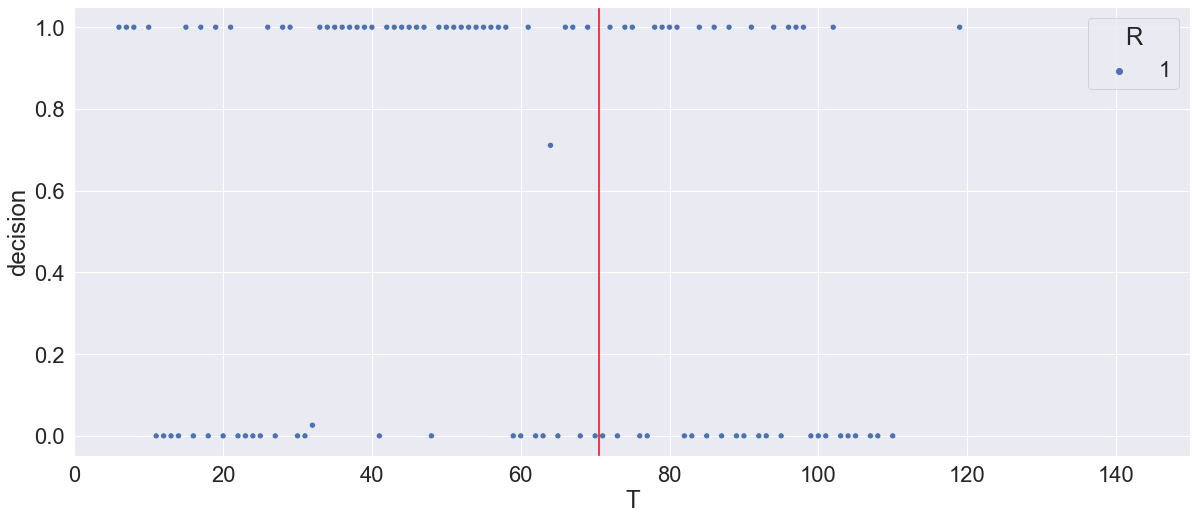

In [35]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


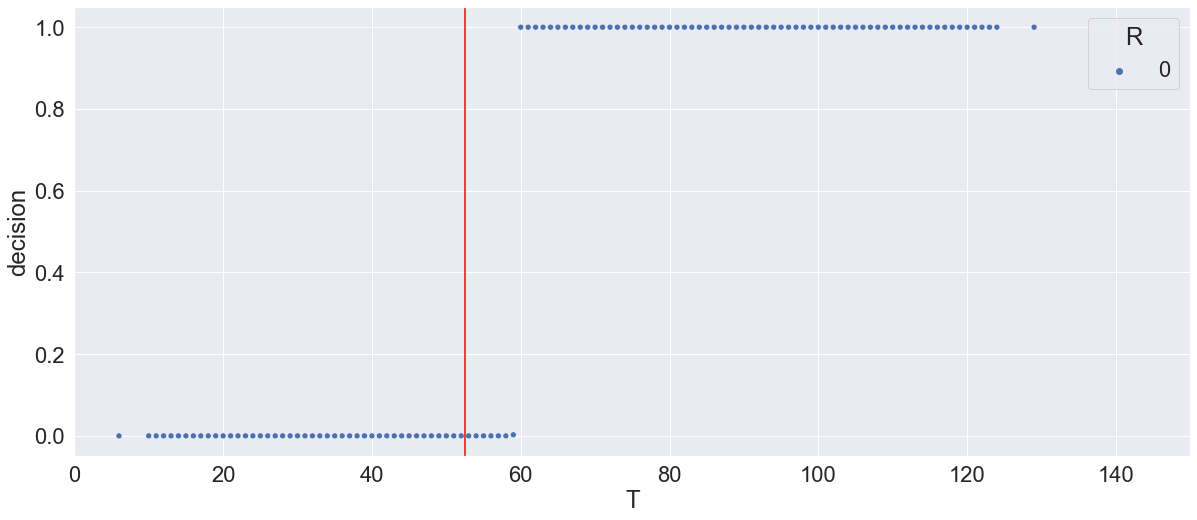

In [36]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [37]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.370394
1,0.394462


In [38]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5328016799975268', '246260.9087999998')

In [39]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

A    0.508014
dtype: float64

In [40]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5328016799975268', '246260.9087999998')

In [41]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.5074844432648304

In [42]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

311975.7784313695

In [43]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

246260.9087999998

In [44]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

244743

In [45]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

A    0.508014
dtype: float64

In [46]:
(admit_decisions['decision'].sum())

484751.99999999965

In [47]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [48]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.379389
1,0.379590


In [49]:
admit_decisions['R_x'].value_counts()

0    670331
1    329669
Name: R_x, dtype: int64